In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Layer, Reshape, Multiply, Conv2D, BatchNormalization, Activation, Add, Input, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedShuffleSplit


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.keras.mixed_precision.set_global_policy('mixed_float16')

2024-12-21 09:43:17.431540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734774197.454171   32192 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734774197.460731   32192 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 09:43:17.484007: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base = '/home/rob/'
csv_file = os.path.join(base, 'ham10000_data/HAM10000_metadata.csv')
img_dir = os.path.join(base, 'ham10000_data/images')
file_ext = '.jpg'

df = pd.read_csv(csv_file)
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(img_dir, x + file_ext))

print(df.head())


     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                        image_path  
0  /home/rob/ham10000_data/images/ISIC_0027419.jpg  
1  /home/rob/ham10000_data/images/ISIC_0025030.jpg  
2  /home/rob/ham10000_data/images/ISIC_0026769.jpg  
3  /home/rob/ham10000_data/images/ISIC_0025661.jpg  
4  /home/rob/ham10000_data/images/ISIC_0031633.jpg  


In [3]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(df, df['dx']):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

print("Train size: ", len(train_df))
print("Train sizes per label and percentage:")
train_counts = train_df['dx'].value_counts()
train_percentages = (train_counts / len(train_df)) * 100
print(train_counts)
print(train_percentages)

print("\nTest size: ", len(test_df))
print("Test sizes per label and percentage:")
test_counts = test_df['dx'].value_counts()
test_percentages = (test_counts / len(test_df)) * 100
print(test_counts)
print(test_percentages)

Train size:  8012
Train sizes per label and percentage:
dx
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64
dx
nv       66.949576
mel      11.108337
bkl      10.971043
bcc       5.129805
akiec     3.270095
vasc      1.422866
df        1.148278
Name: count, dtype: float64

Test size:  2003
Test sizes per label and percentage:
dx
nv       1341
mel       223
bkl       220
bcc       103
akiec      65
vasc       28
df         23
Name: count, dtype: int64
dx
nv       66.949576
mel      11.133300
bkl      10.983525
bcc       5.142287
akiec     3.245132
vasc      1.397903
df        1.148278
Name: count, dtype: float64


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

datagen_train = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_test = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42,
)

class_names = [key for key, _ in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, len(class_names)])
).repeat()
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, len(class_names)])
).repeat()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print("Class Names:", class_names)
print("Train Generator Class Indices:", train_generator.class_indices)
print("Test Generator Class Indices:", test_generator.class_indices)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Class Names: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Train Generator Class Indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Test Generator Class Indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


I0000 00:00:1734774200.585729   32192 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15085 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:0b:00.0, compute capability: 6.0
I0000 00:00:1734774200.586322   32192 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 15259 MB memory:  -> device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:13:00.0, compute capability: 6.0


In [5]:
class CBAM(Layer):
    """
    Convolutional Block Attention Module (CBAM)

    Reference: "CBAM: Convolutional Block Attention Module"
    (Woo et al., ECCV 2018) - https://arxiv.org/abs/1807.06521

    The CBAM block applies both Channel Attention and Spatial Attention
    to refine feature maps adaptively. It consists of two sequential sub-blocks:

    1. Channel Attention Module (CAM):
       - Uses both global average and max pooling operations to generate channel descriptors.
       - Passes them through a shared MLP to produce channel-wise weights.
       - The output is a channel attention map that emphasizes meaningful channels.

    2. Spatial Attention Module (SAM):
       - Uses average and max pooling along the channel dimension to produce spatial descriptors.
       - Applies a convolution (often 7x7) to produce a spatial attention map.
       - This map emphasizes "where" to focus within each channel.

    Parameters
    ----------
    reduction_ratio : int, optional (default=16)
        Reduction ratio for the internal MLP in the channel attention module.

    spatial_kernel_size : int, optional (default=7)
        The kernel size for the spatial attention convolution.
    """
    def __init__(self, reduction_ratio=16, spatial_kernel_size=7, name=None, **kwargs):
        super(CBAM, self).__init__(name=name, **kwargs)
        self.reduction_ratio = reduction_ratio
        self.spatial_kernel_size = spatial_kernel_size

    def build(self, input_shape):
        if len(input_shape) != 4:
            raise ValueError("CBAM input must be in the shape: (batch, height, width, channels)")

        channels = input_shape[-1]
        reduced_channels = max(channels // self.reduction_ratio, 1)

        # Shared MLP for channel attention
        # Two Dense layers: C -> C//r -> C
        self.mlp_dense_1 = Dense(units=reduced_channels,
                                        activation='relu',
                                        use_bias=True,
                                        name='channel_mlp_1')
        self.mlp_dense_2 = Dense(units=channels,
                                        use_bias=True,
                                        name='channel_mlp_2')

        # No weights needed to pre-build for the spatial attention layer
        # since we'll use a Conv2D layer directly on the fly.
        self.spatial_conv = Conv2D(filters=1,
                                          kernel_size=self.spatial_kernel_size,
                                          strides=1,
                                          padding='same',
                                          activation='sigmoid',
                                          use_bias=False,
                                          name='spatial_conv')

        super(CBAM, self).build(input_shape)

    def call(self, inputs, training=False):
        # ----- Channel Attention -----
        # Global average pooling
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=False)  # (batch, C)
        # Global max pooling
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=False)   # (batch, C)

        # Shared MLP transforms
        avg_out = self.mlp_dense_2(self.mlp_dense_1(avg_pool, training=training), training=training)
        max_out = self.mlp_dense_2(self.mlp_dense_1(max_pool, training=training), training=training)

        # Combine and apply sigmoid
        channel_attention = tf.nn.sigmoid(avg_out + max_out)  # (batch, C)

        # Reshape to broadcast
        channel_attention = tf.reshape(channel_attention, [-1, 1, 1, tf.shape(inputs)[-1]])
        channel_refined = inputs * channel_attention

        # ----- Spatial Attention -----
        # Avg and max along channel axis
        avg_spatial = tf.reduce_mean(channel_refined, axis=-1, keepdims=True)  # (batch, H, W, 1)
        max_spatial = tf.reduce_max(channel_refined, axis=-1, keepdims=True)   # (batch, H, W, 1)

        # Concatenate along channel axis
        spatial_concat = tf.concat([avg_spatial, max_spatial], axis=-1)  # (batch, H, W, 2)

        # Apply spatial conv
        spatial_attention = self.spatial_conv(spatial_concat, training=training)  # (batch, H, W, 1)

        # Refine features spatially
        refined_outputs = channel_refined * spatial_attention
        return refined_outputs

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(CBAM, self).get_config()
        config.update({
            'reduction_ratio': self.reduction_ratio,
            'spatial_kernel_size': self.spatial_kernel_size
        })
        return config

In [6]:
# Source: https://github.com/keras-team/keras/blob/v3.7.0/keras/src/applications/resnet.py#L219
# This implementation of ResNet50 is adapted from the official Keras implementation,
# to enable the modification of the architecture to support attention mechanisms.

def identity_block(input_tensor, kernel_size, filters, stage, block, reduction_ratio=16, spatial_kernel_size=7):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of the middle conv layer at the main path
        filters: list of integers, the filters of the 3 conv layers at the main path
        stage: integer, current stage label, used for layer naming
        block: string/char, current block label, used for layer naming
    """
    # Use channels_last
    bn_axis = 3
    filters1, filters2, filters3 = filters
    conv_name_base = 'conv' + str(stage) + '_block' + str(block) + '_'

    x = Conv2D(filters1, (1, 1),
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '1_conv')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '1_bn')(x)
    x = Activation('relu', name=conv_name_base + '1_relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same',
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '2_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '2_bn')(x)
    x = Activation('relu', name=conv_name_base + '2_relu')(x)

    x = Conv2D(filters3, (1, 1),
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '3_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '3_bn')(x)

    x = CBAM(reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size, name=conv_name_base + 'cbam')(x)

    x = Add(name=conv_name_base + 'add')([x, input_tensor])
    x = Activation('relu', name=conv_name_base + 'out')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), reduction_ratio=16, spatial_kernel_size=7):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of the middle conv layer at the main path
        filters: list of integers, the filters of the 3 conv layers at the main path
        stage: integer, current stage label, used for layer naming
        block: string/char, current block label, used for layer naming
        strides: Strides for the first conv layer in the block.
    """
    bn_axis = 3
    filters1, filters2, filters3 = filters
    conv_name_base = 'conv' + str(stage) + '_block' + str(block) + '_'

    x = Conv2D(filters1, (1, 1), strides=strides,
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '1_conv')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '1_bn')(x)
    x = Activation('relu', name=conv_name_base + '1_relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '2_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '2_bn')(x)
    x = Activation('relu', name=conv_name_base + '2_relu')(x)

    x = Conv2D(filters3, (1, 1),
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '3_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '3_bn')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      use_bias=True,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '0_conv')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '0_bn')(shortcut)

    x = CBAM(reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size, name=conv_name_base + 'cbam')(x)

    x = Add(name=conv_name_base + 'add')([x, shortcut])
    x = Activation('relu', name=conv_name_base + 'out')(x)
    return x

def build_resnet50(input_shape, num_classes, hp):

    reduction_ratio = hp.Choice('reduction_ratio', values=[2, 4, 8, 16], default=16)
    spatial_kernel_size = hp.Choice('spatial_kernel_size', values=[3, 5, 7])

    inputs = Input(shape=input_shape, name='input_1')
    bn_axis = 3  # channels_last

    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(inputs)
    x = Conv2D(64, (7, 7), strides=(2, 2),
               padding='valid', use_bias=True,
               kernel_initializer='he_normal',
               name='conv1_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1_pool')(x)

    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block=1, strides=(1, 1), reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=2, reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=3, reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)

    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block=1, reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=2, reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=3, reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=4, reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)

    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block=1, reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=2, reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=3, reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=4, reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=5, reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=6, reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)

    # Stage 5
    x = conv_block(x, 3, [512, 512, 2048], stage=5, block=1, reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=2, reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=3, reduction_ratio=reduction_ratio, spatial_kernel_size=spatial_kernel_size)

    x = GlobalAveragePooling2D(name='avg_pool')(x)

    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs, outputs, name='resnet50')
    return model


In [7]:
def transfer_weights(base_model, target_model):
    for layer in target_model.layers:
        try:
            pretrained_layer = base_model.get_layer(layer.name)
            layer.set_weights(pretrained_layer.get_weights())
        except Exception as e:
            print(f"Could not transfer weights for layer: {layer.name}, due to: {e}")
            pass

In [8]:
def focal_loss(alpha=0.25, gamma=2.0):
    """
    Focal Loss for one-hot encoded multi-class data.

    Parameters:
    - alpha: Weighting factor for positive classes, default is 0.25.
    - gamma: Focusing parameter to reduce the loss contribution from well-classified examples, default is 2.0.

    Returns:
    - A callable loss function for use with Keras models.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())

        # Compute focal loss components
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * y_true * tf.math.pow(1 - y_pred, gamma)

        # Compute weighted loss
        focal_loss = tf.reduce_sum(weights * cross_entropy, axis=-1)
        return tf.reduce_mean(focal_loss)

    return focal_loss_fixed


In [9]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_names),
    y=df['dx']
)

class_weights_dict = {
    train_generator.class_indices[class_name]: weight
    for class_name, weight in zip(class_names, class_weights_array)
}

print(class_weights_dict)

{0: np.float64(4.375273044997815), 1: np.float64(2.78349082823791), 2: np.float64(1.301832835044846), 3: np.float64(12.440993788819876), 4: np.float64(1.2854575792581184), 5: np.float64(0.21338020666879728), 6: np.float64(10.075452716297788)}


In [10]:
def build_model(hp):
    """
    Build the ResNet50 model with SE blocks, allowing hyperparameter tuning for key settings.
    """

    focal_loss_alpha = hp.Choice('focal_loss_alpha', [0.25, 0.5, 0.75, 1.0])
    focal_loss_gamma = hp.Choice('focal_loss_gamma', [1.0, 1.5, 2.0, 2.5])

    base_model = ResNet50(weights="imagenet", include_top=False, pooling=None)
    input_shape = (224, 224, 3)
    num_classes = 7
    custom_resnet = build_resnet50(input_shape, num_classes, hp)

    transfer_weights(base_model, custom_resnet)

    model = custom_resnet

    for layer in model.layers:
        if layer.name.startswith('conv1') or layer.name.startswith('conv2') or layer.name.startswith('conv3') or layer.name.startswith('conv4') or layer.name.startswith('conv5'):
            if not isinstance(layer, CBAM):
                layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=focal_loss(alpha=focal_loss_alpha, gamma=focal_loss_gamma),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

In [11]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_auc',
    max_trials=10,
    directory='bayesian_tuning',
    project_name='resnet50_cbam'
)

Could not transfer weights for layer: input_1, due to: No such layer: input_1. Existing layers are: ['input_layer', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_2_

In [12]:
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(test_df) // BATCH_SIZE

tuner.search(
    train_dataset,
    validation_data=test_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=[
        EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
    ],
    class_weight=class_weights_dict
)

Trial 10 Complete [00h 20m 32s]
val_auc: 0.8845635652542114

Best val_auc So Far: 0.8882278800010681
Total elapsed time: 02h 59m 01s


In [13]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"Reduction Ratio: {best_hps.get('reduction_ratio')}")
print(f"Spatial Kernel Size: {best_hps.get('spatial_kernel_size')}")
print(f"Focal Loss Alpha: {best_hps.get('focal_loss_alpha')}")
print(f"Focal Loss Gamma: {best_hps.get('focal_loss_gamma')}")

Best Hyperparameters:
Reduction Ratio: 16
Spatial Kernel Size: 5
Focal Loss Alpha: 1.0
Focal Loss Gamma: 2.0


In [14]:
best_model = tuner.hypermodel.build(best_hps)

Could not transfer weights for layer: input_1, due to: No such layer: input_1. Existing layers are: ['input_layer_1', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_

In [15]:
for layer in best_model.layers:
    layer.trainable = True

In [16]:
for layer in best_model.layers:
    if isinstance(layer, CBAM):
        print(f"CBAM {layer.name}: Reduction Ratio: {layer.reduction_ratio}, Spatial Kernel Size: {layer.spatial_kernel_size}")

CBAM conv2_block1_cbam: Reduction Ratio: 16, Spatial Kernel Size: 5
CBAM conv2_block2_cbam: Reduction Ratio: 16, Spatial Kernel Size: 5
CBAM conv2_block3_cbam: Reduction Ratio: 16, Spatial Kernel Size: 5
CBAM conv3_block1_cbam: Reduction Ratio: 16, Spatial Kernel Size: 5
CBAM conv3_block2_cbam: Reduction Ratio: 16, Spatial Kernel Size: 5
CBAM conv3_block3_cbam: Reduction Ratio: 16, Spatial Kernel Size: 5
CBAM conv3_block4_cbam: Reduction Ratio: 16, Spatial Kernel Size: 5
CBAM conv4_block1_cbam: Reduction Ratio: 16, Spatial Kernel Size: 5
CBAM conv4_block2_cbam: Reduction Ratio: 16, Spatial Kernel Size: 5
CBAM conv4_block3_cbam: Reduction Ratio: 16, Spatial Kernel Size: 5
CBAM conv4_block4_cbam: Reduction Ratio: 16, Spatial Kernel Size: 5
CBAM conv4_block5_cbam: Reduction Ratio: 16, Spatial Kernel Size: 5
CBAM conv4_block6_cbam: Reduction Ratio: 16, Spatial Kernel Size: 5
CBAM conv5_block1_cbam: Reduction Ratio: 16, Spatial Kernel Size: 5
CBAM conv5_block2_cbam: Reduction Ratio: 16, Spa

In [17]:
alpha = best_hps.get('focal_loss_alpha')
gamma = best_hps.get('focal_loss_gamma')

best_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(alpha=alpha, gamma=gamma),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [18]:
fine_tune_callbacks = [
    ReduceLROnPlateau(monitor='val_auc', factor=0.1, patience=3, mode='max', min_lr=1e-9),
    EarlyStopping(monitor='val_auc', patience=7, mode='max', restore_best_weights=True),
    ModelCheckpoint(filepath='models/resnet50_best.keras', monitor='val_auc', save_best_only=True, mode='max')
]

In [19]:
fine_tune_history = best_model.fit(
    train_dataset,
    validation_data=test_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=fine_tune_callbacks,
    class_weight=class_weights_dict
)

Epoch 1/50


2024-12-21 12:43:42.456977: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_12', 144 bytes spill stores, 140 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_select_fusion_2', 100 bytes spill stores, 96 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_select_fusion_3', 100 bytes spill stores, 96 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_select_fusion_4', 136 bytes spill stores, 132 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_select_fusion_5', 28 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_select_fusion_11', 584 bytes spill stores, 576 bytes spill loa

235/250 ━━━━━━━━━━━━━━━━━━━━ 7s 487ms/step - accuracy: 0.5166 - auc: 0.8364 - loss: 1.0750

2024-12-21 12:46:05.761196: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 4 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_9', 144 bytes spill stores, 140 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_select_fusion_4', 100 bytes spill stores, 96 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_select_fusion_5', 136 bytes spill stores, 132 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_select_fusion_7', 636 bytes spill stores, 628 bytes spill loads
ptxas warning : Regi

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.5213 - auc: 0.8392 - loss: 1.0621

2024-12-21 12:46:15.667174: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_31', 112 bytes spill stores, 112 bytes spill loads



250/250 ━━━━━━━━━━━━━━━━━━━━ 246s 685ms/step - accuracy: 0.5216 - auc: 0.8394 - loss: 1.0613 - val_accuracy: 0.6697 - val_auc: 0.7949 - val_loss: 0.9689 - learning_rate: 1.0000e-05
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 533ms/step - accuracy: 0.6820 - auc: 0.9274 - loss: 0.6200 - val_accuracy: 0.6702 - val_auc: 0.8333 - val_loss: 1.0573 - learning_rate: 1.0000e-05
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 129s 516ms/step - accuracy: 0.7067 - auc: 0.9450 - loss: 0.5092 - val_accuracy: 0.6591 - val_auc: 0.8304 - val_loss: 0.9587 - learning_rate: 1.0000e-05
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 534ms/step - accuracy: 0.7076 - auc: 0.9515 - loss: 0.4695 - val_accuracy: 0.6109 - val_auc: 0.8551 - val_loss: 0.8533 - learning_rate: 1.0000e-05
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 129s 518ms/step - accuracy: 0.7289 - auc: 0.9569 - loss: 0.4414 - val_accuracy: 0.7478 - val_auc: 0.9644 - val_loss: 0.3651 - learning_rate: 1.0000e-05
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 129s 519ms/

In [20]:
# base_model = ResNet50(weights="imagenet", include_top=False, pooling=None)

# # Build ResNet50 with SE Blocks
# input_shape = (224, 224, 3)
# num_classes = 7
# custom_resnet = build_resnet50(input_shape, num_classes)

# # Transfer weights
# transfer_weights(base_model, custom_resnet)

# custom_resnet.summary()

# # Switch the custom_resnet to being the model
# model = custom_resnet

# # Freeze the base model, except for the seblock and cbam layers
# for layer in model.layers:
#     if layer.name.startswith('conv1') or layer.name.startswith('conv2') or layer.name.startswith('conv3') or layer.name.startswith('conv4') or layer.name.startswith('conv5'):
#         if not isinstance(layer, SEBlock):
#             layer.trainable = False



In [21]:
loss, accuracy, auc = best_model.evaluate(test_generator, steps=len(test_generator))

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test AUC: {auc}")

/home/rob/.notebook/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.7870 - auc: 0.9679 - loss: 0.3474
Test Loss: 0.33652064204216003
Test Accuracy: 0.7938092947006226
Test AUC: 0.9695214629173279


In [22]:
# accuracy = history.history['accuracy'] + fine_tune_history.history['accuracy']
# val_accuracy = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
# loss = history.history['loss'] + fine_tune_history.history['loss']
# val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

# epochs = range(1, len(accuracy) + 1)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, accuracy, label='Training Accuracy')
# plt.plot(epochs, val_accuracy, label='Validation Accuracy')
# plt.axvline(x=len(history.history['accuracy']), color='r', linestyle='--', label='Start of Fine-Tuning')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, loss, label='Training Loss')
# plt.plot(epochs, val_loss, label='Validation Loss')
# plt.axvline(x=len(history.history['loss']), color='r', linestyle='--', label='Start of Fine-Tuning')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


In [23]:
y_pred = np.argmax(best_model.predict(test_generator), axis=-1)
y_true = test_generator.classes

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

 1/63 ━━━━━━━━━━━━━━━━━━━━ 6:05 6s/step

2024-12-21 13:19:43.200204: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_30', 112 bytes spill stores, 112 bytes spill loads



63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 286ms/step
Classification Report:
               precision    recall  f1-score   support

       akiec       0.70      0.11      0.19        65
         bcc       0.89      0.38      0.53       103
         bkl       0.56      0.73      0.63       220
          df       0.36      0.57      0.44        23
         mel       0.51      0.55      0.53       223
          nv       0.90      0.92      0.91      1341
        vasc       1.00      0.43      0.60        28

    accuracy                           0.79      2003
   macro avg       0.70      0.53      0.55      2003
weighted avg       0.81      0.79      0.78      2003



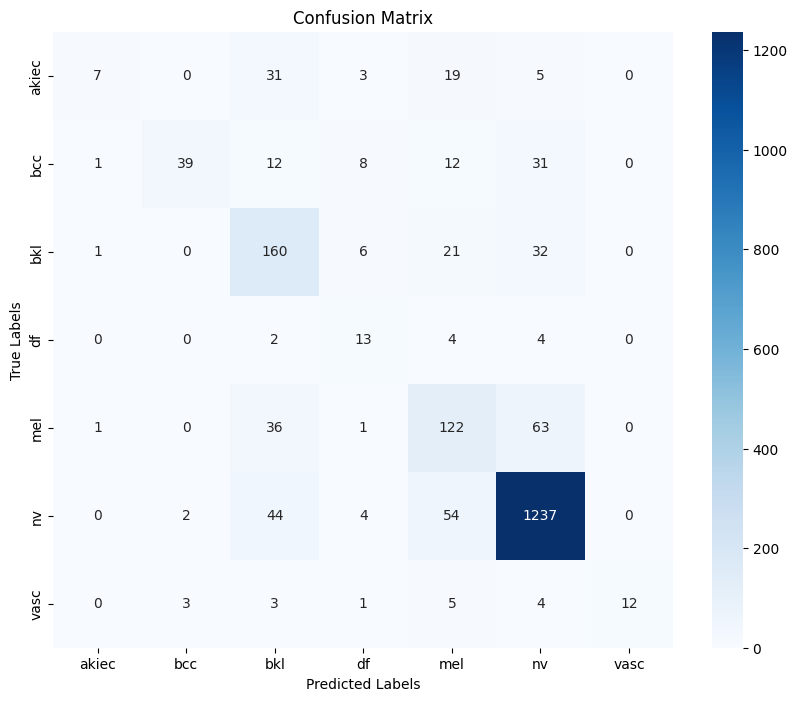

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


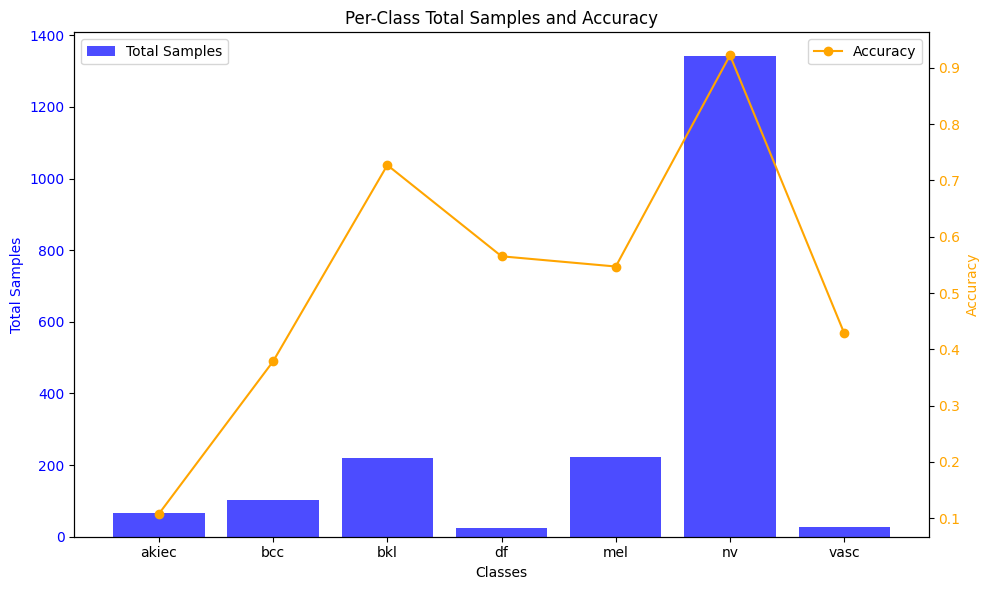

In [25]:
label_counts = np.bincount(y_true)
class_accuracies = np.diag(cm) / label_counts

classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
total_counts = label_counts
accuracies = class_accuracies

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(classes, total_counts, alpha=0.7, label='Total Samples', color='blue')
ax1.set_xlabel('Classes')
ax1.set_ylabel('Total Samples', color='blue')
ax1.set_title('Per-Class Total Samples and Accuracy')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(classes, accuracies, color='orange', marker='o', label='Accuracy')
ax2.set_ylabel('Accuracy', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

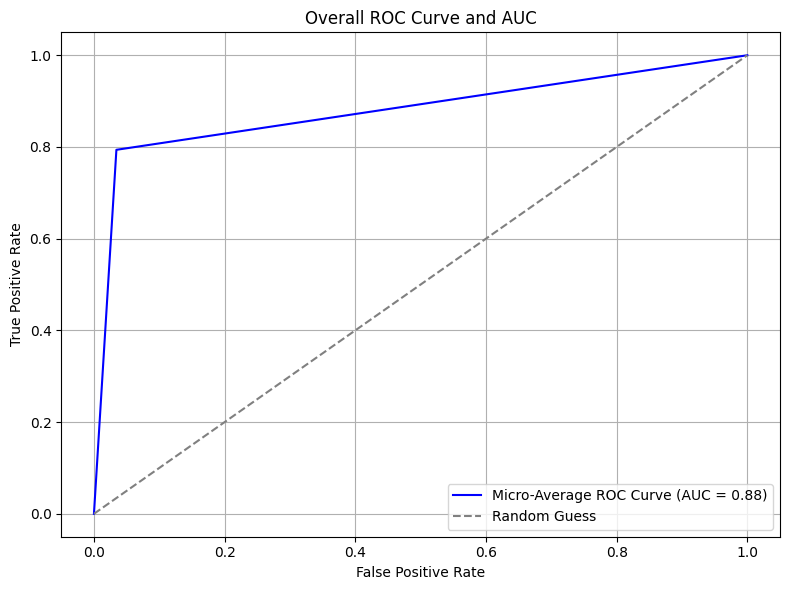

In [26]:
num_classes = len(classes)
y_true_one_hot = label_binarize(y_true, classes=np.arange(num_classes))

y_pred_prob = np.zeros_like(y_true_one_hot)
for i, label in enumerate(y_pred):
    y_pred_prob[i, label] = 1

fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), y_pred_prob.ravel())
roc_auc = roc_auc_score(y_true_one_hot, y_pred_prob, average="micro")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"Micro-Average ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Overall ROC Curve and AUC")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


In [27]:
print("ROC AUC Score (Micro):", roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average='micro'))
print("ROC AUC Score (Macro):", roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average='macro'))
print("ROC AUC Score (Weighted):", roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average='weighted'))

print("AUC Scores Per Class:")
for i, class_name in enumerate(class_names):
    class_roc_auc = roc_auc_score(y_true_one_hot[:, i], y_pred_prob[:, i])
    print(f"{class_name}: {class_roc_auc:.2f}")

ROC AUC Score (Micro): 0.8797220835413546
ROC AUC Score (Macro): 0.7367688851048884
ROC AUC Score (Weighted): 0.8189193111330592
AUC Scores Per Class:
akiec: 0.55
bcc: 0.69
bkl: 0.83
df: 0.78
mel: 0.74
nv: 0.86
vasc: 0.71
